# AutoEncoders for Image Denoising

 - Altanai Bisht ( abishtsu@gmail.com)
 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

from keras.preprocessing import image

# for dirname, _, filenames in os.walk('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/GT'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

## Construct dataset from Images 



*   train_df, noised_df
*   xtrain , xnoised, xtest

For training 
xtrain= train_df[5:]
xnoised= noised_df[0:5]

For validation 
xtest= noised_df[5:]




In [3]:
train_images = sorted(os.listdir('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/train'))
imgsize=(240,320,3)
# newsize=(250, 320)
train_image = []
for im in train_images:
    img = tf.keras.utils.load_img('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/train/'+ im)
    # img = img.resize(newsize)
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)

train_df = np.array(train_image)
train_df.shape

(20, 240, 320, 3)

In [4]:
# matplotlib displays color in BGR format, we are converting that to RGB
def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(1,3):
        ax[i-5].imshow(dataset[i].reshape(100,100), cmap='gray')
    plt.show()

In [5]:
noised_df= []

def add_noise(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.07
    return noisy

for img in train_df:
    noisy= add_noise(img)
    noised_df.append(noisy)

noised_df= np.array(noised_df)
noised_df.shape

(20, 240, 320, 3)

In [6]:
xtrain= train_df[0:7]
xtrain_noisy = noised_df[0:7]
# show_img(xtrain)
print(xtrain.shape)
print(xtrain_noisy.shape)

xtest= train_df[8:]
xtest_noisy= noised_df[8:]
# show_img(xtest)
print(xtest.shape)
print(xtest_noisy.shape)

(7, 240, 320, 3)
(7, 240, 320, 3)
(12, 240, 320, 3)
(12, 240, 320, 3)


##  Encode Decode model and architecture 

In [7]:
# noise_factor = 0.4
# x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
# x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

In [31]:
class NoiseReducer(tf.keras.Model): 
  def __init__(self):
    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      Input(shape=( 240, 320, 3)), 
      Conv2D(100, (3,3), activation='relu', padding='same', strides=2), 
      Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(32, (3,3), activation='relu', padding='same', strides=2)]) 

    self.decoder = tf.keras.Sequential([ 
      Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2DTranspose(100, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')]) 

    #--------------------------

    # Encoder
    # self.encoder = tf.keras.Sequential([ 
    #   Input(shape=(240, 320, 3)), 
    #   Conv2D(128, (3,3), activation='relu', padding='same', strides=2, name='Conv1'), 
    #   MaxPooling2D((2, 2), padding='same'),
    #   Conv2D(64, (3,3), activation='relu', padding='same', strides=2, name='Conv2'),
    #   MaxPooling2D((2, 2), padding='same'),
    #   Conv2D(32, (3,3), activation='relu', padding='same', strides=2, name='Conv3'),
    #   MaxPooling2D((2, 2), padding='same')]) 
   
    # # Decoder
    # self.decoder = tf.keras.Sequential([ 
    #   Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same',name='Conv4'), 
    #   UpSampling2D((2, 2)),
    #   Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same',name='Conv5'), 
    #   UpSampling2D((2, 2)),
    #   Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same',name='Conv6'), 
    #   UpSampling2D((2, 2)),
    #   Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) 

   #--------------------------
    # input_img = Input(shape=(240, 320, 3))
    # #enoder 
    # x = Conv2D(100, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    # x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    # x = Conv2D(100, (3,3), activation='relu', padding='same', name='Conv2')(x)
    # x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    # self.encoder = x

    # #decoder
    # x = Conv2D(100, (3,3), activation='relu', padding='same', name='Conv3')(x)
    # x = UpSampling2D((2,2), name='upsample1')(x)
    # x = Conv2D(100, (3,3), activation='relu', padding='same', name='Conv4')(x)
    # x = UpSampling2D((2,2), name='upsample2')(x)
    # x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    # self.encoder = x

  # gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
  # gaussian_history = gaussian_auto_encoder.fit(gaussian_train_data, train_data, epochs=50, batch_size=32, callbacks=[gaussian_early_stop]) 

  def call(self, x):     
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

### build the model

In [32]:
autoencoder = NoiseReducer()
autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(xtrain_noisy, xtrain, 
                epochs=10, 
                shuffle=True, 
                validation_data=(xtest_noisy, xtest))

Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.0601 - val_loss: 0.0624
Epoch 2/10
1/1 [==============================] - 7s 7s/step - loss: 0.0598 - val_loss: 0.0620
Epoch 3/10
1/1 [==============================] - 8s 8s/step - loss: 0.0595 - val_loss: 0.0616
Epoch 4/10
1/1 [==============================] - 7s 7s/step - loss: 0.0591 - val_loss: 0.0611
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 0.0586 - val_loss: 0.0605
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 0.0580 - val_loss: 0.0597
Epoch 7/10
1/1 [==============================] - 7s 7s/step - loss: 0.0574 - val_loss: 0.0589
Epoch 8/10
1/1 [==============================] - 6s 6s/step - loss: 0.0566 - val_loss: 0.0578
Epoch 9/10
1/1 [==============================] - 6s 6s/step - loss: 0.0557 - val_loss: 0.0566
Epoch 10/10
1/1 [==============================] - 6s 6s/step - loss: 0.0545 - val_loss: 0.0550


### model sumary

In [10]:
autoencoder.summary()

Model: "noise_reducer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30, 40, 32)        78928     
                                                                 
 sequential_1 (Sequential)   (None, 240, 320, 3)       88147     
                                                                 
Total params: 167,075
Trainable params: 167,075
Non-trainable params: 0
_________________________________________________________________


## Run and Runtime 

In [11]:
import time
start = time.time()
encoded_imgs=autoencoder.encoder(xtest).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)
end = time.time()
print("Elapsed time:"+ str(end-start))

Elapsed time:2.1606199741363525


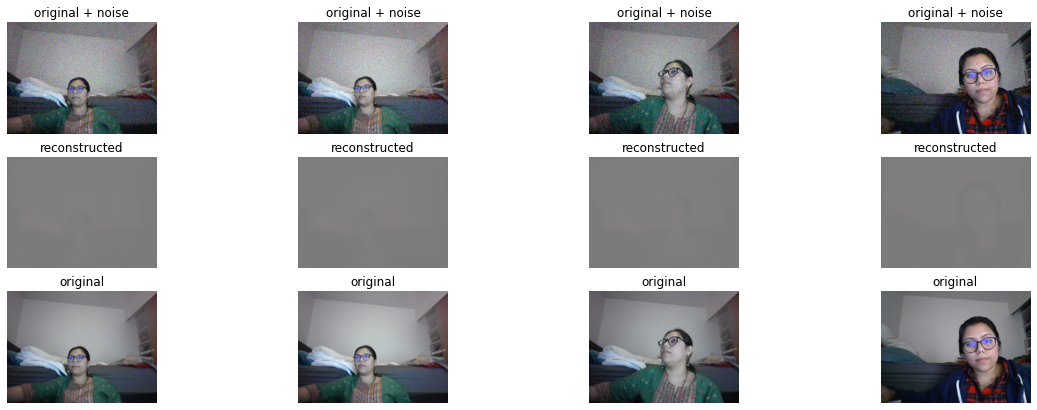

In [12]:
n = 4 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(xtest_noisy[i])) 
  plt.axis('off')
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  plt.axis('off')

  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(xtest[i])) 
  plt.axis('off')
  
plt.show()

## DeNoise Analyzer 

In [13]:
decoded_imgs[0].shape

TensorShape([240, 320, 3])

In [14]:
xtest[i].shape

(240, 320, 3)

In [15]:
import skimage.metrics as measure
i=0
psnr1 = measure.peak_signal_noise_ratio(xtest[i],xtest_noisy[i])
psnr2 = measure.peak_signal_noise_ratio(xtest[i],decoded_imgs[i])
print("PSNR GroundTruth vs noisy " + str(psnr1))
print("PSNR noisy vs denoised " +str(psnr2))
print("PSNR Improvement" + str(psnr2-psnr1))

ssim1 = measure.structural_similarity(xtest[i],xtest_noisy[i],multichannel=True)
ssim2 = measure.structural_similarity(xtest[i],decoded_imgs[i],multichannel=True)
print("SSIM GroundTruth vs noisy " + str(ssim1))
print("SSIM noisy vs denoised " +str(ssim2))
print("SSIM Improvement" + str(ssim2-ssim1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: ignored

Ref:
https://keras.io/examples/vision/autoencoder/